In [1]:
import pennylane as qml
from pennylane import numpy as np

import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Generate circuit == 

# global var
Paras_global = None
Phi_global = None

# Entnalger 
@qml.qnode(dev)
def circuit_1(paras):
    theta_init, tau_1, tau_2 = paras
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    return qml.density_matrix(wires=[0, 1])


@qml.qnode(dev)
def circuit_2(phi):
    global Paras_global
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    # qml.RX(np.pi/2, wires=0)
    # qml.RX(np.pi/2, wires=1)
    
    qml.RY(-np.pi/(2+1e-6), wires=0)
    qml.RY(-np.pi/(2+1e-6), wires=1)
    
    return qml.density_matrix(wires=[0, 1])

@qml.qnode(dev)
def circuit_graphic(phi):
    # select paras
    # Initial_guess = 1e+5, -1e+6, 1e+6
    theta_init, tau_1, tau_2 = np.pi/4, np.pi/2, np.pi/2
   # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1) 
    
    return qml.density_matrix(wires=[0, 1])

In [3]:
Paras_global = 1,1,1
Phi_global = np.pi
res = circuit_2(np.pi)

# np.trace(res)
print(res)

[[ 2.29848847e-01-1.05361309e-17j  2.40497652e-07+6.87567620e-08j
   2.40497652e-07+6.87567620e-08j -3.82573701e-01-1.75087744e-01j]
 [ 2.40497652e-07-6.87567620e-08j  2.72219747e-13+1.02805628e-17j
   2.72157297e-13+1.38777878e-17j -4.52673765e-07-6.87567621e-08j]
 [ 2.40497652e-07-6.87567620e-08j  2.72226686e-13-2.08166817e-17j
   2.72226686e-13+1.02805519e-17j -4.52673765e-07-6.87567621e-08j]
 [-3.82573701e-01+1.75087744e-01j -4.52673765e-07+6.87567621e-08j
  -4.52673765e-07+6.87567621e-08j  7.70151153e-01-1.05361179e-17j]]


In [4]:
# theta_init, tau_1, tau_2 = paras
Paras_global = 1.57100339,1.65353155, 0.99999988
phi_test = np.array([np.pi])

cmp = qml.qinfo.classical_fisher(circuit_2)(phi_test[0])

cmp

tensor([[0.99999983]], requires_grad=True)

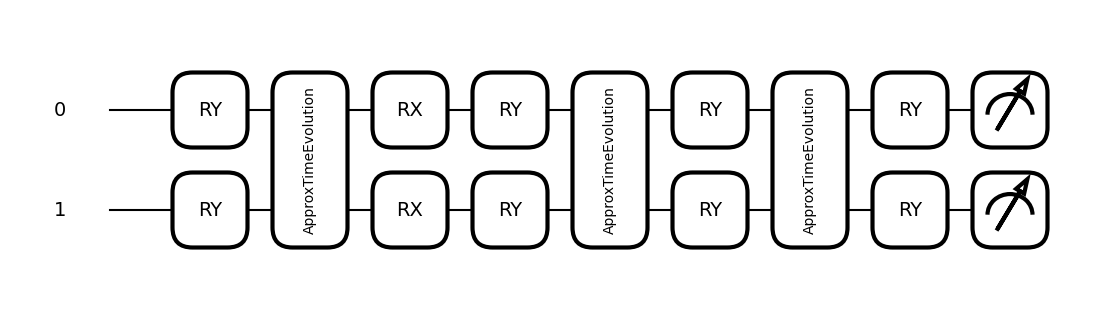

In [5]:
fig, ax = qml.draw_mpl(circuit_graphic)(0)

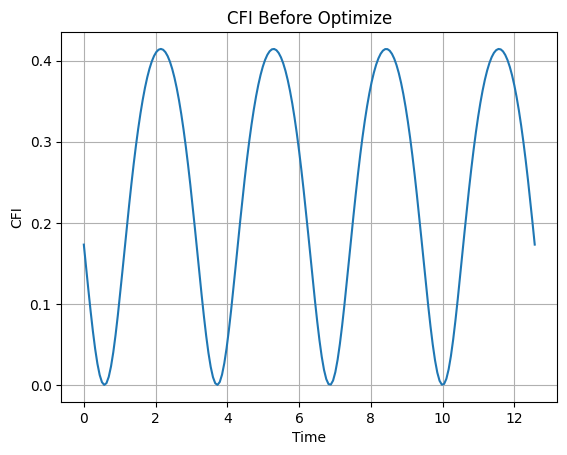

In [6]:
# == Before optimize ==
# == Sweep phi for range ==
Select_bound = np.array([0 + 1e-4, np.pi * 4 + 1e-4])
N = 200

# Searching range array
Phi_range = np.linspace(Select_bound[0], Select_bound[1], N)
CFI_Before_opt = np.zeros(len(Phi_range))

# Select initial paras for entanglers
Initial_guess = 1, 1, 1
Paras_global = Initial_guess[0], Initial_guess[1], Initial_guess[2]


for i in range(len(Phi_range)):
    CFI_Before_opt[i] = qml.qinfo.classical_fisher(circuit_2)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_Before_opt)
plt.title('CFI Before Optimize')
plt.xlabel('Time')
plt.ylabel('CFI')
# plt.legend()
plt.grid()

# Sweep_data

In [7]:
import numpy as np_
# == Before optimize ==
# == Sweep phi for range ==
Select_bound = np.array([0 + 1e-4, np.pi * 4 + 1e-4])
N = 200

# Searching range array
Phi_arange = np.arange(1e-4, 4 * np.pi + 1e-4, 1e-2)
CFI_Before_opt = np.zeros(len(Phi_arange))

# Select initial paras for entanglers
Initial_guess = 1.57100339,1.65353155, 0.99999988
Paras_global = Initial_guess[0], Initial_guess[1], Initial_guess[2]


for i in range(len(Phi_arange)):
    CFI_Before_opt[i] = qml.qinfo.classical_fisher(circuit_2)(Phi_arange[i])

# Plot CFI_before
plt.plot(Phi_arange, CFI_Before_opt)
plt.title('CFI Before Optimize')
plt.xlabel('Time')
plt.ylabel('CFI')
# plt.legend()
plt.grid()

# Sweep_data

In [ ]:
# == Cost_function: using global parameters of Entanglers ==
Phi_global = 2

def Cost_function(paras):
    global Paras_global
    # expect: theta_init, tau_1, tau_2 = paras
    Paras_global = paras
    
    # Call global para for phi
    global Phi_global
    phi = Phi_global
    phi = np.array([ phi ])

    CFI = qml.qinfo.classical_fisher(circuit_2)(phi[0])
    return -CFI

In [ ]:
# == Optimize begin ==
CFI_After_opt = np.zeros(len(Phi_range))

# Entangler paras
row, col = len(Phi_range), 3
Paras_After_opt = [[0 for j in range(col)] for i in range(row)]

# Guess from phi = 2.0
Initial_guess = 1, 1, 1

for i in range(len(Phi_range)):
    phi_global = Phi_range[i].numpy()
    After_SLSQP = sp.optimize.minimize(Cost_function, Initial_guess, method= 'SLSQP')
    
    CFI_After_opt[i] = -After_SLSQP.fun
    
    # Entangler Parameters after OPT
    for j in range(3):
        Paras_After_opt[i][j] = After_SLSQP.x[j]

In [ ]:
# == Three parameters after optimization ==

# theta_init, tau_1, tau_2 = paras
print('theta_init, tau_1, tau_2')

np.isclose(Paras_After_opt[0][0], np.pi/2)

# Paras_After_opt[0][0]

theta_init, tau_1, tau_2


False

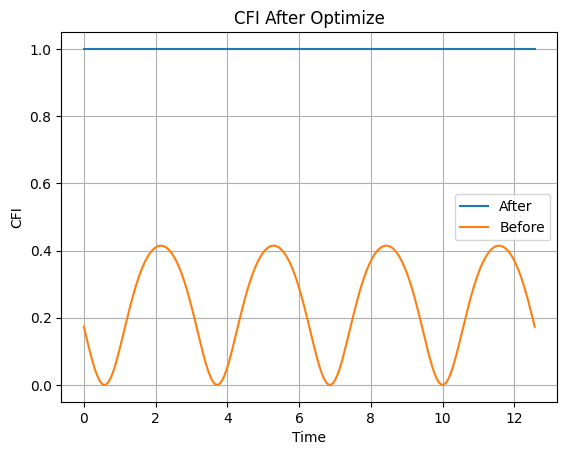

In [ ]:
# == Plot result ==

# Plot CFI_before
plt.plot(Phi_range, CFI_After_opt, label = "After")
plt.plot(Phi_range, CFI_Before_opt, label = "Before")
plt.title('CFI After Optimize')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

In [ ]:
print(CFI_After_opt)

print(len(CFI_After_opt))

[0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.9999

In [ ]:
# == CFI Before OPT ==
CFI = qml.qinfo.classical_fisher(circuit_2)(Phi_range[100])
print('CFI at phi:', Phi_range[100])
print('=>', CFI)

print('')
print('Current Paras:', Paras_global)

CFI at phi: 6.314859102693052
=> [[0.99999324]]

Current Paras: [1.86995086e+00 1.45629703e-04 9.99999966e-01]
